In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from top2vec import Top2Vec
import pickle
from helper import *

from random import sample

from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, TfidfModel
from gensim.models import LsiModel
from gensim import corpora, models, similarities

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from scipy.sparse import csr_matrix

from imblearn.over_sampling import SMOTE

#import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [13]:
df = pd.read_csv("../data/complaints.csv")

In [14]:
df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [15]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,NaN,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,NaN,3379500
2,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198
3,2021-05-31,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,354XX,NaN,NaN,Web,2021-05-31,In progress,Yes,NaN,4417969
4,2021-05-31,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,913XX,NaN,NaN,Web,2021-05-31,In progress,Yes,NaN,4418076


In [9]:
df = df[df['Consumer complaint narrative'].isnull() == False]

In [10]:
df = df[['Consumer complaint narrative', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Company public response']]

In [11]:
df = df.reset_index(drop=True)

In [12]:
df

,Consumer complaint narrative,Product,Sub-product,Issue,Sub-issue,Company public response
0,transworld systems inc. \nis trying to collect...,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,NaN
1,"Over the past 2 weeks, I have been receiving e...",Debt collection,I do not know,Communication tactics,Frequent or repeated calls,NaN
2,"Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/...","Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,Company has responded to the consumer and the ...
3,Hello This complaint is against the three cred...,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,Company has responded to the consumer and the ...
4,Today XX/XX/XXXX went online to dispute the in...,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Personal information incorrect,Company has responded to the consumer and the ...
...,...,...,...,...,...,...
725237,I was on automatic payment for my car loan. In...,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,NaN
725238,I recieved a collections call from an unknown ...,Debt collection,I do not know,Communication tactics,Threatened to take legal action,Company has responded to the consumer and the ...
725239,"On XXXX XXXX, 2015, I contacted XXXX XXXX, who...",Mortgage,FHA mortgage,"Loan servicing, payments, escrow account",NaN,NaN
725240,I can not get from chase who services my mortg...,Mortgage,Conventional adjustable mortgage (ARM),"Loan servicing, payments, escrow account",NaN,NaN


In [8]:
# Number of rows where "sub-issue = Nan"
df[df['Sub-issue'].isnull()== True].shape[0]

155205

In [9]:
df.Product.unique()

array(['Debt collection',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Money transfer, virtual currency, or money service', 'Mortgage',
       'Vehicle loan or lease', 'Student loan',
       'Credit card or prepaid card', 'Checking or savings account',
       'Credit card', 'Payday loan, title loan, or personal loan',
       'Consumer Loan', 'Payday loan', 'Bank account or service',
       'Credit reporting', 'Other financial service', 'Money transfers',
       'Prepaid card', 'Virtual currency'], dtype=object)

In [10]:
len(df.Product.unique())

18

In [11]:
category_index = {}
index_num = 0
for category in df.Product.unique():
    category_index[category] = index_num
    index_num += 1

In [12]:
category_index

{'Debt collection': 0,
 'Credit reporting, credit repair services, or other personal consumer reports': 1,
 'Money transfer, virtual currency, or money service': 2,
 'Mortgage': 3,
 'Vehicle loan or lease': 4,
 'Student loan': 5,
 'Credit card or prepaid card': 6,
 'Checking or savings account': 7,
 'Credit card': 8,
 'Payday loan, title loan, or personal loan': 9,
 'Consumer Loan': 10,
 'Payday loan': 11,
 'Bank account or service': 12,
 'Credit reporting': 13,
 'Other financial service': 14,
 'Money transfers': 15,
 'Prepaid card': 16,
 'Virtual currency': 17}

In [13]:
category_index.keys()

dict_keys(['Debt collection', 'Credit reporting, credit repair services, or other personal consumer reports', 'Money transfer, virtual currency, or money service', 'Mortgage', 'Vehicle loan or lease', 'Student loan', 'Credit card or prepaid card', 'Checking or savings account', 'Credit card', 'Payday loan, title loan, or personal loan', 'Consumer Loan', 'Payday loan', 'Bank account or service', 'Credit reporting', 'Other financial service', 'Money transfers', 'Prepaid card', 'Virtual currency'])

In [14]:
df['Product_index'] = df['Product'].astype('category').cat.codes

In [15]:
df

,Consumer complaint narrative,Product,Sub-product,Issue,Sub-issue,Company public response,Product_index
0,transworld systems inc. \nis trying to collect...,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,NaN,7
1,"Over the past 2 weeks, I have been receiving e...",Debt collection,I do not know,Communication tactics,Frequent or repeated calls,NaN,7
2,I am a victim of identity theft. My personal i...,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,6
3,"Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/...","Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,Company has responded to the consumer and the ...,6
4,Hello This complaint is against the three cred...,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,Company has responded to the consumer and the ...,6
...,...,...,...,...,...,...,...
707403,I was on automatic payment for my car loan. In...,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,NaN,2
707404,I recieved a collections call from an unknown ...,Debt collection,I do not know,Communication tactics,Threatened to take legal action,Company has responded to the consumer and the ...,7
707405,"On XXXX XXXX, 2015, I contacted XXXX XXXX, who...",Mortgage,FHA mortgage,"Loan servicing, payments, escrow account",NaN,NaN,10
707406,I can not get from chase who services my mortg...,Mortgage,Conventional adjustable mortgage (ARM),"Loan servicing, payments, escrow account",NaN,NaN,10


In [16]:
df [df['Consumer complaint narrative'].str.contains('Can I')].iloc[0]['Consumer complaint narrative']

'I have been trying to get my credit report from Equifax but have been unsuccessful. Through the online method, the questions asked that are used for " security purposes \'\' were all asked about accounts which I have never had and used to deny my request for my report. I have also called to have it sent and was told by recorded message that I should receive it within 15 days, that was over a month ago. This company has been used to deny me getting services without having to place deposits and the information forwarded has been false and I can not verify what is being reported without seeing that information. Can I sue these people?'

In [17]:
df['Consumer complaint narrative'].iloc[225]

'I called Capital One to see if they have a valued customer credit for the annual fee since we are in the holiday season. The representative advised that there is nothing available. Several years ago I had an issue with the annual fee with one of my other Capital One cards and a supervisor advised that they can switch my card to a Quick Silver card in which it does not have an annual fee. I am wondering why this associate could not suggest another Capital One card that does not have an annual fee. I asked if there was another card that Capital One can offer which does not carry the late fee. The associate finally did provide a solution to transition into Venture One card which does not carry an annual fee. This was done however In feel that Capital One should adjust this annual fee since I have been a loyal customer for many years and I have many accounts with Capital One.'

In [18]:
#df.to_csv('df.csv')

In [19]:
len(df.Product.unique()) == len(df.Product_index.unique())

True

In [21]:
df_sample = df.sample(n=1000)

In [22]:
df_17 = df[df.Product_index == 17]
df_9 = df[df.Product_index == 9]
df_11 = df[df.Product_index == 11]
df_14 = df[df.Product_index == 14]
df_12 = df[df.Product_index == 12]

In [23]:
df_sample = pd.concat([df_sample,df_17,df_9,df_11,df_14,df_12])

In [24]:
df_sample

,Consumer complaint narrative,Product,Sub-product,Issue,Sub-issue,Company public response,Product_index
303684,Hello The company who is involved is Specializ...,Mortgage,Conventional home mortgage,Problem with a credit reporting company's inve...,NaN,Company has responded to the consumer and the ...,10
609615,I bought a vehicle and got an auto loan throug...,Bank account or service,Other bank product/service,"Account opening, closing, or management",NaN,NaN,0
619819,Card was previously added to the XXXX payments...,"Money transfer, virtual currency, or money ser...",Mobile or digital wallet,Problem adding money,NaN,Company has responded to the consumer and the ...,8
467246,Bank of America is applying my monthly payment...,Credit card or prepaid card,General-purpose credit card or charge card,"Other features, terms, or problems",Problem with balance transfer,Company has responded to the consumer and the ...,4
566134,"I am being charged late fees every month, and ...",Student loan,Non-federal student loan,Dealing with my lender or servicer,Don't agree with fees charged,NaN,15
...,...,...,...,...,...,...,...
701130,I borrowed XXXX on XX/XX/XXXX and XXXX on XX/X...,Payday loan,NaN,Charged fees or interest I didn't expect,NaN,Company has responded to the consumer and the ...,12
701960,In XXXX I took out a Payday Loan from Blue Hoi...,Payday loan,NaN,Charged fees or interest I didn't expect,NaN,NaN,12
707213,A few years ago I applied for a payday loan at...,Payday loan,NaN,Charged fees or interest I didn't expect,NaN,NaN,12
707305,Roughly 10+ years ago I closed out my accounts...,Payday loan,NaN,Payment to acct not credited,NaN,NaN,12


In [38]:
documents = list(df_sample['Consumer complaint narrative'])

In [39]:
df_17.shape[0] + df_9.shape[0] +df_11.shape[0] +df_14.shape[0] + df_12.shape[0]

5001

In [40]:
len(documents)

6001

In [41]:
clean_documents_sample = []
for document in documents:
    clean_documents_sample.append(no_tokenize(document))

In [42]:
# with open('test.txt', "wb") as fp:
#     pickle.dump(clean_documents_sample, fp) #pickling

# # with open('test.txt', "rb") as fp:
# #     b = pickle.load(fp) #unpickling

In [45]:
X_sample = tfidfvectorizer.fit_transform(clean_documents_sample)

In [46]:
X_sample

<6001x11815 sparse matrix of type '<class 'numpy.float64'>'
	with 290110 stored elements in Compressed Sparse Row format>

In [47]:
y_sample = df_sample.Product_index.array

In [48]:
# DATA balance check
df.groupby('Product_index').count()

,Consumer complaint narrative,Product,Sub-product,Issue,Sub-issue,Company public response
Product_index,,,,,,
0,14885,14885,14885,14885,0,8627
1,31187,31187,31187,31187,31163,16898
2,9472,9472,9472,9472,0,3631
3,18838,18838,0,18838,0,9361
4,52915,52915,52915,52915,52018,25762
5,31588,31588,0,31588,31588,18985
6,261973,261973,261973,261973,256113,154628
7,139691,139691,139691,139691,139691,57634
8,14029,14029,14029,14029,0,3041


In [49]:
tsvd = TruncatedSVD(n_components=200)

In [50]:
X_tsvd = tsvd.fit_transform(X_sample)

In [51]:
X_tsvd.shape

(6001, 200)

In [52]:
y_sample

<PandasArray>
[10,  0,  8,  4, 15,  5, 15,  6,  6,  4,
 ...
 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
Length: 6001, dtype: int8

In [53]:
# over_sample = SMOTE()
# X, y = over_sample.fit_resample(X_tsvd,y_sample)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_tsvd, y_sample, test_size=0.2)

In [55]:
over_sample = SMOTE()
X, y = over_sample.fit_resample(X_train,y_train)

In [56]:
X_train = X
y_train = y

In [57]:
# unique, counts = np.unique(y, return_counts=True)
# np.asarray((unique, counts)).T

In [58]:
# unique, counts = np.unique(y_test, return_counts=True)
# np.asarray((unique, counts)).T

In [59]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.4)

In [60]:
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

## XGBoost

In [63]:
# #XGboost needs a specific format of data, called Dmatrix. 

# D_train = xgb.DMatrix(X_train, label=y_train)
# D_test = xgb.DMatrix(X_test, label=y_test)


In [ ]:
clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)

grid.fit(X_train, y_train)

In [ ]:
preds = grid.predict(X_test)

## RandomForest Classifier 

In [231]:
rf = RandomForestClassifier(n_estimators=300)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300)

In [243]:
# save the model to disk
filename = 'rf_classifier.sav'
pickle.dump(rf, open(filename, 'wb'))
 

In [ ]:
# # some time later...
 
# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)

In [232]:
preds = rf.predict(X_test)

In [233]:
y_test

<PandasArray>
[ 6,  7,  6, 10, 10,  6,  6,  5, 12,  5,
 ...
  6,  4,  6,  6,  4, 10, 15,  6, 16,  6]
Length: 141482, dtype: int8

In [234]:
preds

array([ 6,  7,  6, ...,  6, 16,  6], dtype=int8)

In [235]:
accuracy = accuracy_score(preds, y_test)
precision = precision_score(preds, y_test, labels=labels, average = 'macro')
recall = recall_score(preds, y_test, labels=labels, average = 'macro')
f1 = f1_score(preds, y_test, labels=labels, average = 'macro')

/Users/hyorimlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hyorimlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hyorimlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


In [236]:
accuracy = round(float(str(accuracy)),4)*100
precision= round(float(str(precision)),4)*100
recall = round(float(str(recall)),4)*100
f1 = round(float(str(f1)),4)*100

In [237]:
matrix = confusion_matrix(y_test, preds)

In [238]:
category_index

{'Debt collection': 0,
 'Credit reporting, credit repair services, or other personal consumer reports': 1,
 'Money transfer, virtual currency, or money service': 2,
 'Mortgage': 3,
 'Vehicle loan or lease': 4,
 'Student loan': 5,
 'Credit card or prepaid card': 6,
 'Checking or savings account': 7,
 'Credit card': 8,
 'Payday loan, title loan, or personal loan': 9,
 'Consumer Loan': 10,
 'Payday loan': 11,
 'Bank account or service': 12,
 'Credit reporting': 13,
 'Other financial service': 14,
 'Money transfers': 15,
 'Prepaid card': 16,
 'Virtual currency': 17}

In [245]:
matrix

array([[  865,  1277,     5,    85,   257,     6,    58,    73,   160,
            3,    84,     0,     0,    13,    12,     4,    19],
       [  420,  4495,     2,    31,   553,    21,   100,    88,   424,
            1,    85,     0,     0,    31,     1,     4,    12],
       [   27,    42,   312,    42,    55,    35,   141,   213,    16,
            0,   109,     0,     7,   182,     0,    83,   537],
       [   62,   160,    20,  1014,  1849,    49,   278,   271,    54,
            1,    44,     0,     0,    14,     3,    16,    19],
       [   69,   736,    23,   569,  7696,    37,   562,   338,   224,
            0,    98,     0,     0,    43,    25,    34,   120],
       [   13,    26,    33,    67,   115,  3001,  2491,   456,     6,
            0,    80,     0,     0,    11,     0,    35,    38],
       [   38,   301,    88,   145,  1222,  2016, 44718,  2103,    70,
            0,   722,     0,     0,   145,     0,   434,   568],
       [   59,   272,   114,   154,   707,   303

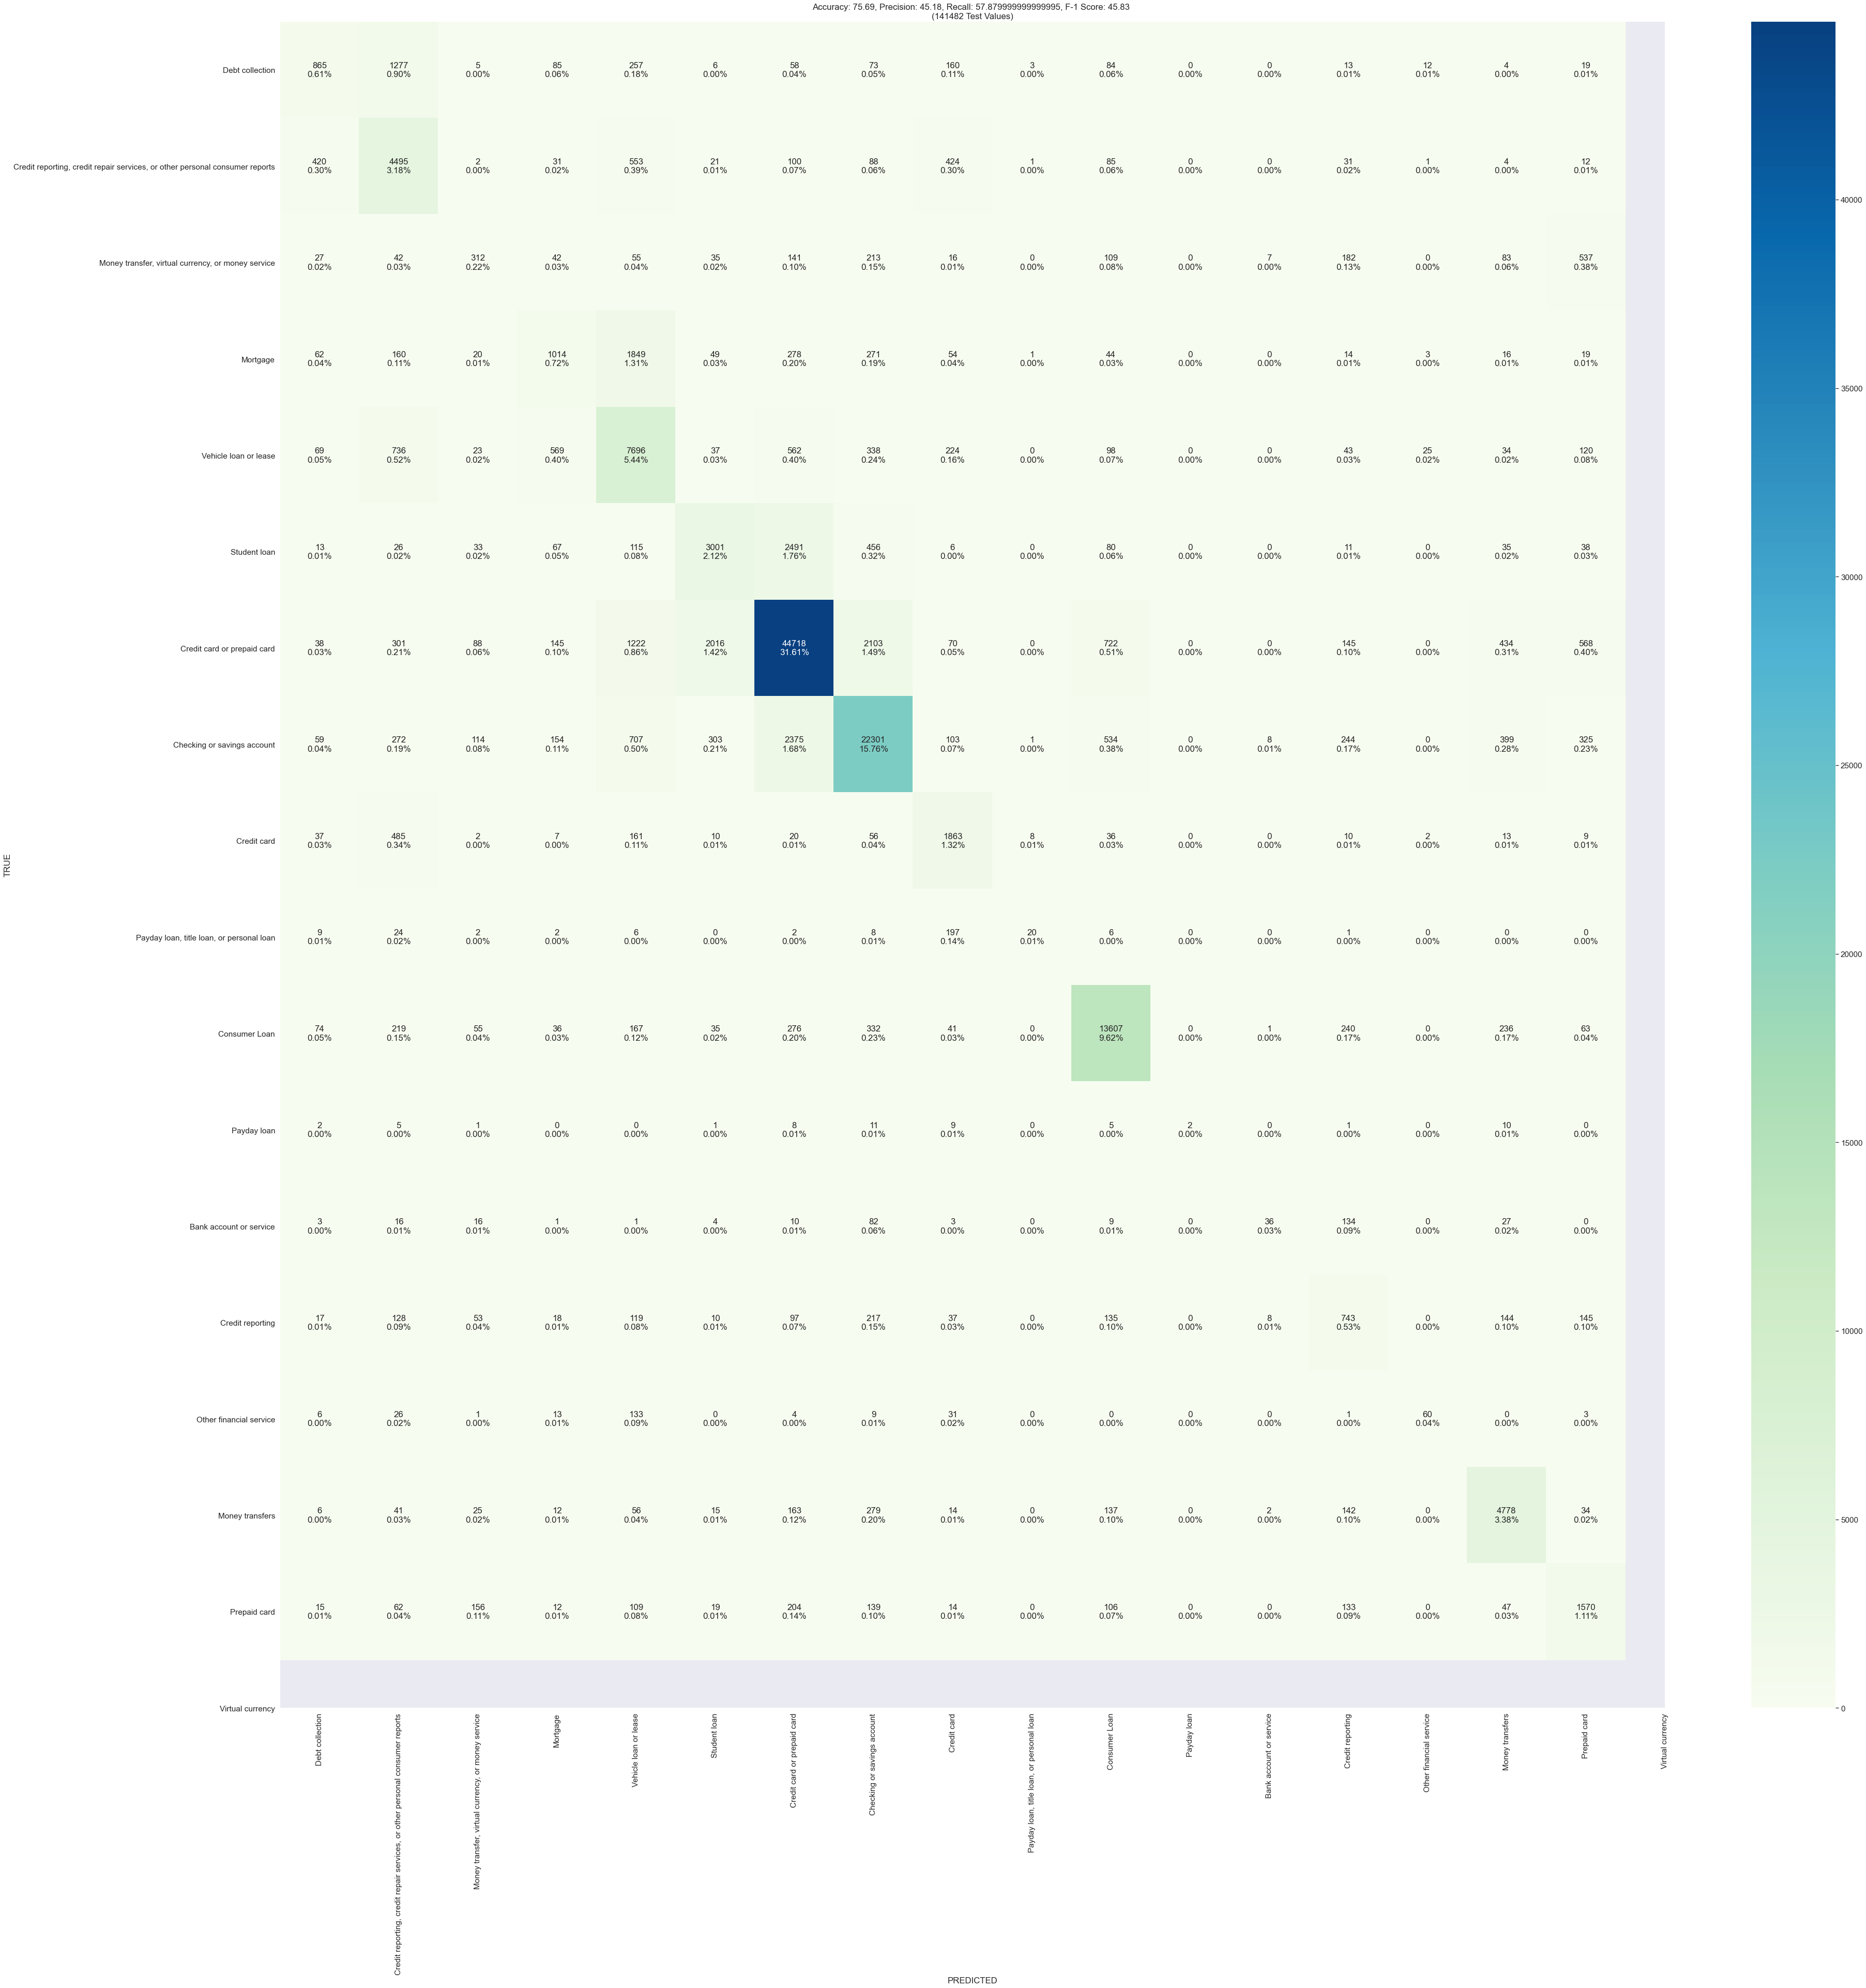

In [239]:
# Build the plot
plt.figure(figsize=(60,60))
labels = np.arange(0,18)
group_counts = ["{0:0.0f}\n".format(value) for value in matrix .flatten()]
group_percentages = ["{0:.2%}".format(value) for value in matrix .flatten()/np.sum(matrix)]

box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_counts,group_percentages)]
box_labels = np.asarray(box_labels).reshape(matrix .shape[0],matrix .shape[1])


sns.set(font_scale=1.4)

sns.heatmap(matrix , annot=box_labels, fmt='', cmap='GnBu',
            xticklabels=['Fraud', 'Not Fraud'],yticklabels=['Fraud', 'Not Fraud'])

# sns.heatmap(matrix, annot=True, annot_kws={'size':15},
#             cmap=plt.cm.Reds, linewidths=0.2)



# Add labels to the plot
class_names = category_index.keys()
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks+.5, class_names, rotation=90)
plt.yticks(tick_marks2 , class_names, rotation=0)
plt.xlabel('PREDICTED')
plt.ylabel('TRUE')
plt.title(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F-1 Score: {f1} \n({len(y_test)} Test Values)')
plt.savefig('confusion_rf.jpg')
plt.show()

capturing complaints 

intrum - start a convo w ads 
build lexicon for complaints 

1. between classifications of complaints, classif of inquiries 
2. group lexicon 


brute force idea of basic inquiries 

1. basic inquiries (normal questions) -> saturation 
2. focused inquiries (financial or account services/nomenclustrer etc): what is my interest rate / balance ? 
3. boarderline complaints (fiancial/account irregularities): i found discrepancy... what is the charge, late fee... 

complaints: 

1. autorization - I didn't authorize the charge


all parts, dicept the convo ? 

